<a href="https://colab.research.google.com/github/BridgetteBXP13/CS-4395.001---Human-Language-Technologies/blob/main/Text%20Classification/TextClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification

In this notebook we decided to do text classification for job postings, based on details within the job postings description, salary, location, etc. We will classify the job posting as likely to be real or fake. This dataset can be found [here](https://www.kaggle.com/datasets/shivamb/real-or-fake-fake-jobposting-prediction) on Kaggle.

## Importing Our Dataset

Here we simply have to import pandas and use it's prewritten functions to read our .csv dataset into a pandas dataframe. Our dataset was from kaggle but I also stored it [here on Github](https://github.com/BridgetteBXP13/CS-4395.001---Human-Language-Technologies/blob/main/Text%20Classification/fake_job_postings.csv).

In [7]:
# Importing pandas
import pandas as pd
# Reading in the data from csv from Github
url = 'https://raw.githubusercontent.com/BridgetteBXP13/CS-4395.001---Human-Language-Technologies/main/Text%20Classification/fake_job_postings.csv'
df = pd.read_csv(url)
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


## Graphing our Categories

Here we used pandas .hist() function to create a histogram. Then I customized it to make it took a bit nicer using ax, which is the axe object from MatPlotLib

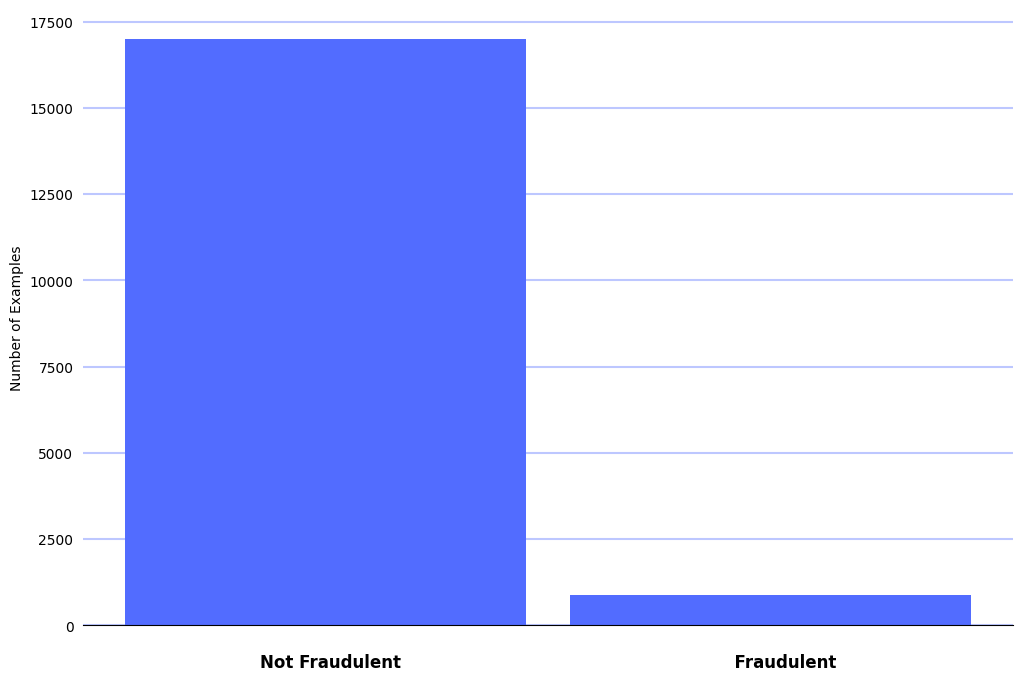

In [8]:
# Graphs Showing Distribution
ax = df.hist(column='fraudulent', bins=2, grid=False, figsize=(12,8),
             color='#526CFF', zorder=2, rwidth=.9)
ax = ax[0]

for x in ax:

  # Despine
  x.spines['right'].set_visible(False)
  x.spines['top'].set_visible(False)
  x.spines['left'].set_visible(False)

  # Switch off ticks
  x.tick_params(axis='both', which='both', bottom=False, top=False, 
                labelbottom=False, left=False, right=False, labelleft=True)
  
  # Draw horizontal axis lines
  x.set_yticks((0, 2500, 5000, 7500, 10000, 12500, 15000, 17500))
  vals = x.get_yticks()
  for tick in vals:
    x.axhline(y=tick, linestyle='solid', alpha=None, color='#BDC7FF', zorder=1)

  # Remove title
  x.set_title("")

  # Set x-axis label
  x.set_xlabel("Not Fraudulent                                                          Fraudulent",
               labelpad=20, weight='bold', size=12)

  # Set y-axis label
  x.set_ylabel("Number of Examples")

## About our Data

Our dataset is designed to predict whether a job post is real (not fraudulent) or fake (fraudulent). For our purposes we will focus on the descriptions for text classification. Also many of the other columns have many missing values. As you can see from the graph above, there is a huge amount of real (not fraudulent) compared to fake (fraudulent). This is likely because most fake (fraudulent) job postings are taken down and are generally less common. Which makes them more difficult to collect. Having a large gap between our categories will pose a few challenges creating an accurate model.

This dataset can be found [here](https://www.kaggle.com/datasets/shivamb/real-or-fake-fake-jobposting-prediction) on Kaggle.

## Preparing Our Data

### Splitting into Train, Test and Validate

Here we use sklearn's train, test, and split function to create our train, test, and validate sets. To do this we first get the train and validate. Then we use the train data and use the function on it again to get our updated train and test. This way we get our validation, train, and test.

### Vectorization

Here we have to vectorize our data because our models will not take text directly as input. So we have to change our raw text into vectorized numbers to be model friendly. To do this we wrote a simple function to create a matrix given the shape and of specific shape.

In [9]:
# some necessary packages
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder

df = df[['description', 'fraudulent']]

df.description = df.description.astype('str')
df.fraudulent = df.fraudulent.astype('category')

print(df.head())

np.random.seed(1234)
i = np.random.rand(len(df)) < 0.8
j = np.random.rand(len(df)) < 0.8
train = df[i]
test = df[~i]
print("train data size: ", train.shape)
print("test data size: ", test.shape)

# set up X and Y
num_labels = 2
vocab_size = 25000
batch_size = 100

# fit the tokenizer on the training data
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train.description)

x_train = tokenizer.texts_to_matrix(train.description, mode='tfidf')
x_test = tokenizer.texts_to_matrix(test.description, mode='tfidf')

encoder = LabelEncoder()
encoder.fit(train.fraudulent)
y_train = encoder.transform(train.fraudulent)
y_test = encoder.transform(test.fraudulent)

# check shape
print("train shapes:", x_train.shape, y_train.shape)
print("test shapes:", x_test.shape, y_test.shape)
print("test first five labels:", y_test[:5])

                                         description fraudulent
0  Food52, a fast-growing, James Beard Award-winn...          0
1  Organised - Focused - Vibrant - Awesome!Do you...          0
2  Our client, located in Houston, is actively se...          0
3  THE COMPANY: ESRI – Environmental Systems Rese...          0
4  JOB TITLE: Itemization Review ManagerLOCATION:...          0
train data size:  (14342, 2)
test data size:  (3538, 2)
train shapes: (14342, 25000) (14342,)
test shapes: (3538, 25000) (3538,)
test first five labels: [0 0 0 0 0]


## Sequential Model

### Creating our Sequential Model

This model was created using Tensorflow's keras by getting a Sequential model object. Then we add multiple layers sequentially. (Hense the name Sequential)

In [10]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

### Compile our Sequential Model

Then we simply use the compile the model using the compile funcion with given optimizer, loss, and metrics.

In [11]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

### Training our Sequential Model

We train our model using the .fit function giving it our train and validation data. We have to specify the batch size and number of epochs we want. Typically you can play with these numbers to adjust them for higher accuracy and to avoid underfitting/overfitting.

In [12]:
history = model.fit(x_train, 
                    y_train, 
                    epochs=20, 
                    batch_size=batch_size, 
                    verbose=1, 
                    validation_split=.1)

Epoch 1/20
130/130 [==============================] - 1s 8ms/step - loss: 0.2040 - accuracy: 0.9468 - val_loss: 0.4171 - val_accuracy: 0.8105
Epoch 2/20
130/130 [==============================] - 1s 6ms/step - loss: 0.0658 - accuracy: 0.9765 - val_loss: 0.3833 - val_accuracy: 0.8718
Epoch 3/20
130/130 [==============================] - 1s 6ms/step - loss: 0.0237 - accuracy: 0.9933 - val_loss: 0.4789 - val_accuracy: 0.8941
Epoch 4/20
130/130 [==============================] - 1s 6ms/step - loss: 0.0079 - accuracy: 0.9988 - val_loss: 0.5370 - val_accuracy: 0.8934
Epoch 5/20
130/130 [==============================] - 1s 7ms/step - loss: 0.0052 - accuracy: 0.9991 - val_loss: 0.6400 - val_accuracy: 0.8976
Epoch 6/20
130/130 [==============================] - 1s 6ms/step - loss: 0.0042 - accuracy: 0.9991 - val_loss: 0.7462 - val_accuracy: 0.8948
Epoch 7/20
130/130 [==============================] - 1s 7ms/step - loss: 0.0023 - accuracy: 0.9995 - val_loss: 0.7958 - val_accuracy: 0.8955
Epoch 

### Evaluating on our Model

While the code above can show our accuracy and loss while we trained for both our train and validation data. We must test it on our test data to check if our model can generalize well. We do this by using the evaluate function and passing it our test data we set aside earlier.

In [13]:
score = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)
print('Accuracy: ', score[1])

36/36 [==============================] - 0s 3ms/step - loss: 0.2144 - accuracy: 0.9813
Accuracy:  0.9813454151153564


### Evaluating with More Metrics

Below we can take the direct probabilities and predictions our model made on the test data. With these we can utilize sklearn's metrics to print our confusion matrix and classification report which highlight how well our model did. Below you can see it has very good sensitivity (detecting that it is not fraud) but not as good specificity (detecting when it is exactly fraud). This was expected and not suprising because of how limited examples our data had for fraudlent aka fake jobs shown by the graph above.

In [14]:
# get predictions so we can calculate more metrics
pred = model.predict(x_test)
pred_labels = [1 if p>0.5 else 0 for p in pred]

from sklearn.metrics import confusion_matrix, classification_report
print("\nResults on testing data:\n")
print("Confusion Matrix")
print(confusion_matrix(y_test, pred_labels))
print("Classification Report:")
print(classification_report(y_test, pred_labels))


111/111 [==============================] - 0s 1ms/step

Results on testing data:

Confusion Matrix
[[3375   10]
 [  56   97]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3385
           1       0.91      0.63      0.75       153

    accuracy                           0.98      3538
   macro avg       0.95      0.82      0.87      3538
weighted avg       0.98      0.98      0.98      3538



## RNN

RNN are Recurrent Neural Networks and are more complext than the base sequential models such as the one above. There are many different types of RNN and they are usually focused for sequential or time series data. They are often used for stock market prediction, machine translation, and text generation. RNN does this by saving the output of a particular layer and feeding it back to the input to predict the output.

### SimpleRNN

Here we build a model with sequential layers but implement embedding and SimpleRNN layers.

In [15]:
model = models.Sequential()
model.add(layers.Embedding(10000, 32))
model.add(layers.SimpleRNN(32))
model.add(layers.Dense(1, activation='sigmoid'))

This summary shows how many parameters will be in each layer. In total there will be 322,113!

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          320000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 322,113
Trainable params: 322,113
Non-trainable params: 0
_________________________________________________________________


#### Compiling our SimpleRNN

Next we compile just like before! This time we are using the rmsprop optimizer, binary crossentopy for loss and accuracy for metrics.

In [21]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


#### Training our SimpleRNN

Next we train just like before, although we have fewer epochs because it will take much longer as well as a slightly larger batch size.

In [ ]:
history = model.fit(x_train,
                    y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
16/90 [====>.........................] - ETA: 37:27 - loss: 0.1528 - accuracy: 0.9653

#### Testing and Evaluating our SimpleRNN

While the code above can show our accuracy and loss while we trained for both our train and validation data. We must test it on our test data to check if our model can generalize well. We do this by using the evaluate function and passing it our test data we set aside earlier.

In [ ]:
from sklearn.metrics import classification_report

pred = model.predict(x_test)
pred = [1.0 if p>= 0.5 else 0.0 for p in pred]
print(classification_report(y_test, pred))

### LSTM

Here we build a model with sequential layers but implement embedding and LSTM (Long Short-Term Memory) layers. LSTM is another type of RNN.

In [ ]:
model = models.Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

This summary shows how many parameters will be in each layer. In total there will be \<AMOUNT_HERE\>!

In [ ]:
model.summary()

#### Compiling our LSTM

Next we compile just like before! We are using the adam optimizer, binary crossentopy for loss and accuracy for metrics just like for SimpleRNN.

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

#### Training our LSTM

Next we train just like before with SimpleRNN.

In [ ]:
history = model.fit(train_data,
                    train_labels,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

#### Testing and Evaluating our LSTM

While the code above can show our accuracy and loss while we trained for both our train and validation data. We must test it on our test data to check if our model can generalize well. We do this by using the evaluate function and passing it our test data we set aside earlier.

In [ ]:
pred = model.predict(test_data)
pred = [1.0 if p>= 0.5 else 0.0 for p in pred]
print(classification_report(test_labels, pred))

### GRU

Here we build a model with sequential layers but implement embedding and GRU(Gated Recurrent Unit) layers. GRU is another type of RNN.

In [ ]:
model = models.Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.GRU(32))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_data,
                    train_labels,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

In [ ]:
pred = model.predict(test_data)
pred = [1.0 if p>= 0.5 else 0.0 for p in pred]
print(classification_report(test_labels, pred))

## CNN

In [ ]:
# Try CNN

# build a Sequential model 1D convnet

model = models.Sequential()
model.add(layers.Embedding(max_features, 128, input_length=maxlen)) 
model.add(layers.Conv1D(32, 7, activation='relu')) 
model.add(layers.MaxPooling1D(5)) 
model.add(layers.Conv1D(32, 7, activation='relu')) 
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

In [ ]:
model.summary()

In [ ]:
# compile

model.compile(optimizer='adam',  # set learning rate
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# train

history = model.fit(train_data,
                    train_labels,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

In [ ]:
from sklearn.metrics import classification_report

pred = model.predict(test_data)
pred = [1.0 if p>= 0.5 else 0.0 for p in pred]
print(classification_report(test_labels, pred))

In [ ]:
# Try Different Embeddings (BERT, ELMo, etc HuggingFace)

## Embeddings

Here we will try different Embeddings, which are really just pretrained well made models which we can fine-tune for our task. The models we chose for our fake job classification is Distilbert, JobClassifier, and Job-Description-Classifier. These can be found here:

[Distilbert](https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)

[JobClassifier](https://huggingface.co/CleveGreen/JobClassifier_v3_gpt)

[Job-Description-Classifier](https://huggingface.co/tkuye/job-description-classifier)


### Distilbert

Here we will start with Distilbert. We have to load the transformers and tokenizers used by Distilbert. We also loaded the model and the optimizer.

In [ ]:
# Import the transformers and setup our model and tokenizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
# Setup our tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
# Setup our model
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
# Compile our model
model.compile(optimizer=optimizer, loss=model.hf_comput_loss, metrics=['accuracy'])

#### Prepping Our Data

We have to prep our data for Distilbert specifically using it's tokenizers and convert them into the Tensorflow Dataset Objects

In [ ]:
# Tokenizing and Encoding our input text
train_encodings = tokenizer(X_train, truncation=True, padding=True)
val_encodings = tokenizer(X_val, truncation=True, padding=True)

# Creating our Tensorflow Dataset Objects
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_cats
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_cats
))

#### Training and Fine Tuning the Model

Here we use fit just like before to fine tune the model to our data set for classifying fake and real jobs.

In [ ]:
model.fit(train_dataset.shuffle(1000).batch(32), epochs=100, batch_size=32,
          validation_data=val_dataset.shuffle(1000).batch(32))

#### Evaluating Our Model

Here we had to write a for loop to traverse through each test pair, because Bert doesn't have a nice report like sklearn. From there we take the output and increment whether it was a true positive, false positive, false negative, or true negative. From those we can call our print_metrics() function which will calculate and print the confusion matrix, accuracy, sensativity, and specificity.

In [ ]:
# This evaluates our model by for every test input
# From each it will calculate the true positive, false positive, false negative, and true negative
# We will use these to calculate the accuracy, confusion matrix, specificity, and sensativity of our model
tp, fp, fn, tn = 0
for test_data in zip(X_test, y_test):
  predict_input = loaded_tokenizer.encode(test_data[0],
                                          truncation=True,
                                          padding=True,
                                          return_tensors="tf")
  output = loaded_model(predict_input)[0]
  if output >= .5:
    predicted = 1
  else: 
    predicted = 0

  if predicted == test_data[1] and predicted == 1:
    tp += 1
  elif predicted != test_data[1] and predicted == 1:
    fp += 1
  elif predicted == test_data[1] and predicted == 0:
    tn += 1
  else:
    fn += 1
  
def print_metrics(tp, fp, fn, tn):
  # Prints the confusion matrix
  print("\nConfusion Matrix:\n")
  print(tp + "\t" + fp + '\n' + fn + '\t' + tn)
  print("\nAccuracy: ", (tp+tn)/(tp+fp+fn+tn))
  print("Sensativity: ", tp/(tp+fn))
  print("Specificity: ", tn/(fp+tn))

# Print out our evaluation metrics
print_metrics(tp, fp, fn, tn)


### JobClassifier

Next we will try JobClassifier. We have to load the transformers and tokenizers used by JobClassifier. We also loaded the model and the optimizer.

In [ ]:
# Import the transformers and setup our model and tokenizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
# Setup our tokenizer
tokenizer = AutoTokenizer.from_pretrained("CleveGreen/JobClassifier_v3_gpt"
# Setup our model
model = AutoModelForSequenceClassification.from_pretrained("CleveGreen/JobClassifier_v3_gpt")
# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
# Compile our model
model.compile(optimizer=optimizer, loss=model.hf_comput_loss, metrics=['accuracy'])

#### Prepping Our Data

We have to prep our data for JobClassifier specifically using it's tokenizers and convert them into the Tensorflow Dataset Objects. Just like we did for Distilbert.

In [ ]:
# Tokenizing and Encoding our input text
train_encodings = tokenizer(X_train, truncation=True, padding=True)
val_encodings = tokenizer(X_val, truncation=True, padding=True)

# Creating our Tensorflow Dataset Objects
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_cats
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_cats
))

#### Training and Fine Tuning the Model

Here we use fit just like before to fine tune the model to our data set for classifying fake and real jobs. Just like we did before.

In [ ]:
model.fit(train_dataset.shuffle(1000).batch(32), epochs=100, batch_size=32,
          validation_data=val_dataset.shuffle(1000).batch(32))

#### Evaluating Our Model

Here we had to write a for loop to traverse through each test pair, because Bert doesn't have a nice report like sklearn. From there we take the output and increment whether it was a true positive, false positive, false negative, or true negative. From those we can call our print_metrics() function which will calculate and print the confusion matrix, accuracy, sensativity, and specificity.

In [ ]:
# This evaluates our model by for every test input
# From each it will calculate the true positive, false positive, false negative, and true negative
# We will use these to calculate the accuracy, confusion matrix, specificity, and sensativity of our model
tp, fp, fn, tn = 0
for test_data in zip(X_test, y_test):
  predict_input = loaded_tokenizer.encode(test_data[0],
                                          truncation=True,
                                          padding=True,
                                          return_tensors="tf")
  output = loaded_model(predict_input)[0]
  if output >= .5:
    predicted = 1
  else: 
    predicted = 0

  if predicted == test_data[1] and predicted == 1:
    tp += 1
  elif predicted != test_data[1] and predicted == 1:
    fp += 1
  elif predicted == test_data[1] and predicted == 0:
    tn += 1
  else:
    fn += 1
  
def print_metrics(tp, fp, fn, tn):
  # Prints the confusion matrix
  print("\nConfusion Matrix:\n")
  print(tp + "\t" + fp + '\n' + fn + '\t' + tn)
  print("\nAccuracy: ", (tp+tn)/(tp+fp+fn+tn))
  print("Sensativity: ", tp/(tp+fn))
  print("Specificity: ", tn/(fp+tn))

# Print out our evaluation metrics
print_metrics(tp, fp, fn, tn)


### Job-Description-Classifier

Finally we will try Job-Description-Classifier. We have to load the transformers and tokenizers used by Job-Description-Classifier. We also loaded the model and the optimizer.

In [ ]:
# Import the transformers and setup our model and tokenizer
from transformers import AutoTokenizer, AutoModelForTokenClassification
# Setup our tokenizer
tokenizer = AutoTokenizer.from_pretrained("tkuye/job-description-classifier")
# Setup our model
model = AutoModelForSequenceClassification.from_pretrained("tkuye/job-description-classifier")
# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
# Compile our model
model.compile(optimizer=optimizer, loss=model.hf_comput_loss, metrics=['accuracy'])

#### Prepping Our Data

We have to prep our data for Job-Description-Classifier specifically using it's tokenizers and convert them into the Tensorflow Dataset Objects. Just like we did for Distilbert and JobClassifier.

In [ ]:
# Tokenizing and Encoding our input text
train_encodings = tokenizer(X_train, truncation=True, padding=True)
val_encodings = tokenizer(X_val, truncation=True, padding=True)

# Creating our Tensorflow Dataset Objects
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_cats
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_cats
))

#### Training and Fine Tuning the Model

Here we use fit just like before to fine tune the model to our data set for classifying fake and real jobs. Just like we did before.

In [ ]:
model.fit(train_dataset.shuffle(1000).batch(32), epochs=100, batch_size=32,
          validation_data=val_dataset.shuffle(1000).batch(32))

#### Evaluating Our Model

Here we had to write a for loop to traverse through each test pair, because Bert doesn't have a nice report like sklearn. From there we take the output and increment whether it was a true positive, false positive, false negative, or true negative. From those we can call our print_metrics() function which will calculate and print the confusion matrix, accuracy, sensativity, and specificity.

In [ ]:
# This evaluates our model by for every test input
# From each it will calculate the true positive, false positive, false negative, and true negative
# We will use these to calculate the accuracy, confusion matrix, specificity, and sensativity of our model
tp, fp, fn, tn = 0
for test_data in zip(X_test, y_test):
  predict_input = loaded_tokenizer.encode(test_data[0],
                                          truncation=True,
                                          padding=True,
                                          return_tensors="tf")
  output = loaded_model(predict_input)[0]
  if output >= .5:
    predicted = 1
  else: 
    predicted = 0

  if predicted == test_data[1] and predicted == 1:
    tp += 1
  elif predicted != test_data[1] and predicted == 1:
    fp += 1
  elif predicted == test_data[1] and predicted == 0:
    tn += 1
  else:
    fn += 1
  
def print_metrics(tp, fp, fn, tn):
  # Prints the confusion matrix
  print("\nConfusion Matrix:\n")
  print(tp + "\t" + fp + '\n' + fn + '\t' + tn)
  print("\nAccuracy: ", (tp+tn)/(tp+fp+fn+tn))
  print("Sensativity: ", tp/(tp+fn))
  print("Specificity: ", tn/(fp+tn))

# Print out our evaluation metrics
print_metrics(tp, fp, fn, tn)

In [ ]:
# Analyze Perfomance of all